<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-야후-파이낸스로-주가-구하기" data-toc-modified-id="1.-야후-파이낸스로-주가-구하기-1">1. 야후 파이낸스로 주가 구하기</a></span></li><li><span><a href="#2.-MinMaxScaler-함수-적용" data-toc-modified-id="2.-MinMaxScaler-함수-적용-2">2. MinMaxScaler 함수 적용</a></span></li><li><span><a href="#3.-데이터셋-준비하기" data-toc-modified-id="3.-데이터셋-준비하기-3">3. 데이터셋 준비하기</a></span></li><li><span><a href="#4.-모델-생성하기" data-toc-modified-id="4.-모델-생성하기-4">4. 모델 생성하기</a></span></li><li><span><a href="#5.-내일의-종가-출력" data-toc-modified-id="5.-내일의-종가-출력-5">5. 내일의 종가 출력</a></span></li></ul></div>

**cf1) 텐서플로 설치 시 오류 해결**

conda update -n base conda
    
Python 버전3.5 ~ 3.7 에서만 설치가 가능하므로, conda create -n tensor_37_env python=3.7 로 3.7 버전 가상환경 생성

conda activate tensor_37_env (가상환경 종료 시에는 conda deactivate)

conda install tensorflow

**cf2) 텐서플로 가상환경에서 jupyter notebook 실행**

conda activate tensor_37_env

pip install jupyter notebook

(pip install ipykernel)

가상환경에 커널 연결 -> python -m ipykernel install --user --name tensor_37_env --display-name "[Tensorflow_37_env]"

jupyter notebook을 입력하여 실행

# 1. 야후 파이낸스로 주가 구하기

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yf
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [3]:
def StockData(code, date):
    yf.pdr_override()
    df = pdr.get_data_yahoo(f'{code}.KS', start=f'{date}')
    df = df[['Open','High','Low','Volume','Close']]
    return df

In [4]:
df = StockData('005930', '2019-01-01')     # 삼성전자
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Volume,Close
Date,,,,,
2019-01-02,39400.0,39400.0,38550.0,7847664,38750.0
2019-01-03,38300.0,38550.0,37450.0,12471493,37600.0
2019-01-04,37450.0,37600.0,36850.0,14108958,37450.0
2019-01-07,38000.0,38900.0,37800.0,12748997,38750.0
2019-01-08,38000.0,39200.0,37950.0,12756554,38100.0


# 2. MinMaxScaler 함수 적용

계산 시간 단축을 위해 OHLVC 데이터를 0 ~1 사이의 값으로 변환

In [5]:
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)     # 0으로 나누기 에러 방지

In [6]:
df_x = MinMaxScaler(df)
df_y = df_x[['Close']]

x = df_x.values.tolist()
y = df_y.values.tolist()

In [7]:
df_x.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 751 entries, 2019-01-02 to 2022-01-14
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    751 non-null    float64
 1   High    751 non-null    float64
 2   Low     751 non-null    float64
 3   Volume  751 non-null    float64
 4   Close   751 non-null    float64
dtypes: float64(5)
memory usage: 35.2 KB


In [8]:
df_y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 751 entries, 2019-01-02 to 2022-01-14
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   751 non-null    float64
dtypes: float64(1)
memory usage: 11.7 KB


In [9]:
x[-1]

[0.7615894039720689,
 0.684121621620466,
 0.7644824311476458,
 0.11180547483479439,
 0.7441643323982369]

In [10]:
y[-1]

[0.7441643323982369]

# 3. 데이터셋 준비하기

In [11]:
data_x = []
data_y = []
window_size = 10     # 이전 10일 동안 OHLVC 데이터로 다음 날 종가 예측
for i in range(len(y) - window_size):
    x2 = x[i : i + window_size]
    y2 = y[i + window_size]
    data_x.append(x2)
    data_y.append(y2)
print("이전 10일 동안 OHLVC : ", x2, "\n다음 날 종가 : ", y2)

이전 10일 동안 OHLVC :  [[0.808893093659775, 0.719594594593379, 0.7910731244049553, 0.21919646759047254, 0.7721755368799772], [0.7842951750221678, 0.7077702702690747, 0.7834757834742954, 0.15764923810250525, 0.7628384687193971], [0.7824030274346596, 0.7027027027015157, 0.7872744539396253, 0.13761424093946514, 0.7703081232478612], [0.7824030274346596, 0.6993243243231431, 0.7511870845189911, 0.2820475945958821, 0.7460317460303528], [0.7426679280969865, 0.6756756756745343, 0.754985754984321, 0.14320121202783265, 0.7366946778697727], [0.7691579943221019, 0.689189189188025, 0.7701804368456406, 0.16791494783352398, 0.7628384687193971], [0.7691579943221019, 0.684121621620466, 0.7644824311476458, 0.11015217707643618, 0.757236227823049], [0.7748344370846266, 0.6993243243231431, 0.7815764482416304, 0.14640330749467984, 0.7740429505120933], [0.7956480605472173, 0.709459459458261, 0.7929724596376202, 0.12181339489102708, 0.7740429505120933], [0.7918637653722008, 0.7043918918907021, 0.7796771130089655, 

In [12]:
# 훈련용 데이터셋 70%
train_size = int(len(data_y) * 0.7)
train_x = np.array(data_x[0:train_size])
train_y = np.array(data_y[0:train_size])

# 테스트용 데이터셋 30%
test_size = len(data_y) - train_size
test_x = np.array(data_x[train_size:len(data_x)])
test_y = np.array(data_y[train_size:len(data_y)])

# 4. 모델 생성하기

In [13]:
model = Sequential()
model.add(LSTM(units=10, activation='relu', return_sequences=True, input_shape=(window_size, 5)))     # (10,5) 입력 형태를 가지는 LSTM층
model.add(Dropout(0.1))     # 입력값의 10%를 0으로 치환하여 과적합 방지
model.add(LSTM(units=10, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.summary()

model.compile(optimizer='adam', loss='mean_squared_error')     # 최적화 도구:adam, 손실 함수:MSE
model.fit(train_x, train_y, epochs=60, batch_size=30)          # epochs:전체 데이터셋 학습 횟수, batch_size:한 번에 제공되는 훈련 데이터 개수
pred_y = model.predict(test_x)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 10)            640       
                                                                 
 dropout (Dropout)           (None, 10, 10)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10)                840       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 1,491
Trainable params: 1,491
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
18/18 [==============================] - 2s

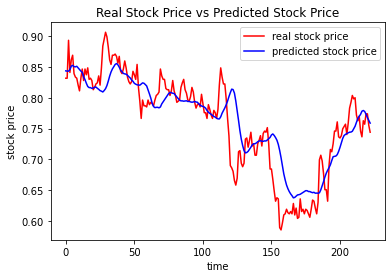

In [14]:
plt.figure()
plt.plot(test_y, color='r', label='real stock price')
plt.plot(pred_y, color='b', label='predicted stock price')
plt.title('Real Stock Price vs Predicted Stock Price')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend(loc='best')
plt.show()

# 5. 내일의 종가 출력

MinMaxScaler로 변환하기 전후의 데이터를 이용하여 내일의 예측 가격 y를 구함

    관계식 : df.Close[-1] : df_y.Close[-1] = y : pred_y[-1]

In [15]:
print("다음 날 예측 종가 : ", df.Close[-1]*pred_y[-1]/df_y.Close[-1])

다음 날 예측 종가 :  [78839.93]
